# Quality control on the beetle risk pipeline

This notebook performs some quality control on the data products produced in the beetle risk data pipeline.

Run this cell below before running any other cell in the notebook:

In [1]:
from config import *
import matplotlib.pyplot as plt
from rasterio.plot import show

## Metadata and tag checks

Define a function to read the metadata from a GeoTIFF and read it from all of the new GeoTIFFs in the risk classes dataset:

In [2]:
def get_meta(fp):
    with rio.open(fp) as src:
        profile = src.profile
        tags = src.tags()
    
    return (profile, tags)

all_meta = [get_meta(fp) for fp in risk_class_dir.glob("*.tif")]

Assert that all metadata and tags are the same for all files in the dataset:

In [3]:
assert(all(x == all_meta[0] for x in all_meta))

## Validating regridded forest mask

In [9]:
forest_fp = base_dir.joinpath("ak_forest_mask.tif")
ncar_forest_fp = scratch_dir.joinpath("ak_forest_mask_ncar_3338.tif")
temp_ncar_clip_fp = scratch_dir.joinpath("ncar_template_clipped_3338.tif")

Verify that the new forest mask, `ncar_forest_fp`, is on the same grid as a GeoTIFF derived from a sample NCAR file, `temp_ncar_clip_fp`:

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 274, 'height': 163, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(11941.015207563296, 0.0, -1787504.172181093,
       0.0, -11941.015207563296, 2368277.0885445094), 'tiled': False, 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 274, 'height': 163, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(11941.015207563296, 0.0, -1787504.172181093,
       0.0, -11941.015207563296, 2368277.0885445094), 'tiled': False, 'interleave': 'band'}


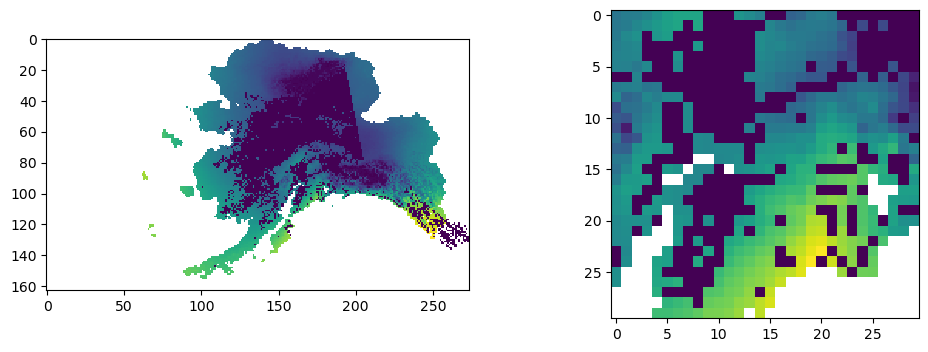

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

with rio.open(temp_ncar_clip_fp) as src:
    ncar_arr = src.read(1)
    print(src.profile)
    
with rio.open(ncar_forest_fp) as src:
    forest_arr = src.read(1).astype(float)
    print(src.profile)
    
forest_arr[forest_arr == 0] = np.nan
ax[0].imshow(ncar_arr, interpolation="none")
ax[0].imshow(forest_arr, interpolation="none")

ax[1].imshow(ncar_arr[80:110, 155:185], interpolation="none")
ax[1].imshow(forest_arr[80:110, 155:185], interpolation="none")
    
plt.show()

The left figure shows an overal view that the forest mask appears to correspond well with the shape of Alaska in the NCAR dataset. The right image shows a zoomed in view of Cook Inlet + Prince William Sound, showing complete overlap of pixel boundaries between layers.

Notice that the file metadata are essentially same too, only differing in their nodata value (float vs 0).

Also view the general agreement of the new forest mask with the original forest mask:

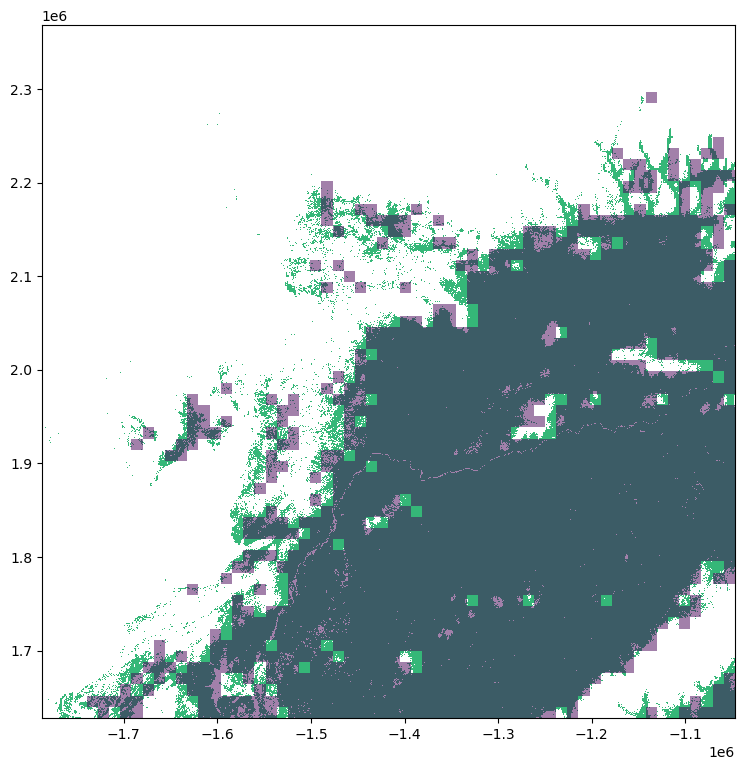

In [10]:
from rasterio.windows import Window


fig, ax = plt.subplots(1, figsize=(12, 9))

window = Window(5e3, 1e3, 3e3, 3e3)
with rio.open(forest_fp) as src:
    forest_arr = src.read(1, window=window).astype(float)
    forest_transform = src.transform

forest_arr[forest_arr == 0] = np.nan
show(forest_arr, interpolation="none", ax=ax, vmin=0, vmax=1.5, transform=forest_transform)

ncar_window=Window(104, 21, 62, 62)
with rio.open(ncar_forest_fp) as src:
    ncar_forest_arr = src.read(1, window=ncar_window).astype(float)
    ncar_forest_transform = src.transform

ncar_forest_arr[ncar_forest_arr == 0] = np.nan
show(ncar_forest_arr, interpolation="none", ax=ax, alpha=0.5, transform=ncar_forest_transform)
    
plt.show()

This image shows the original forest mask in green and the new NCAR forest mask in translucent purple for a widnow over western AK. This results in a dark green color where the two rasters match - looks pretty good.